<a href="https://colab.research.google.com/github/Elijas/movie-review-sentiment-polarity-classifier/blob/master/notebook/04__ulmfit_fastai_proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://files.fast.ai/models/wt103/fwd_wt103.h5

--2019-08-04 15:38:56--  http://files.fast.ai/models/wt103/fwd_wt103.h5
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462387687 (441M)
Saving to: ‘fwd_wt103.h5.1’

fwd_wt103.h5.1      100%[===================>] 440.97M   105MB/s    in 4.3s    

2019-08-04 15:39:00 (102 MB/s) - ‘fwd_wt103.h5.1’ saved [462387687/462387687]



In [2]:
!wget http://files.fast.ai/models/wt103/bwd_wt103.h5

--2019-08-04 15:39:01--  http://files.fast.ai/models/wt103/bwd_wt103.h5
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462387687 (441M)
Saving to: ‘bwd_wt103.h5.1’

bwd_wt103.h5.1      100%[===================>] 440.97M   107MB/s    in 4.3s    

2019-08-04 15:39:05 (102 MB/s) - ‘bwd_wt103.h5.1’ saved [462387687/462387687]



In [3]:
!wget http://files.fast.ai/models/wt103/itos_wt103.pkl

--2019-08-04 15:39:06--  http://files.fast.ai/models/wt103/itos_wt103.pkl
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161252 (4.0M)
Saving to: ‘itos_wt103.pkl.1’

itos_wt103.pkl.1    100%[===================>]   3.97M  18.0MB/s    in 0.2s    

2019-08-04 15:39:06 (18.0 MB/s) - ‘itos_wt103.pkl.1’ saved [4161252/4161252]



In [4]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

from pathlib import Path

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [0]:
from functools import partial
import io
import os

import pandas as pd
import numpy as np
import nltk
import fastai
from fastai import *
from fastai.text import * 
from sklearn.model_selection import train_test_split

nltk.download('punkt', quiet=True, raise_on_error=True)
nltk.download('stopwords', quiet=True, raise_on_error=True)

# Constants
TEST_SPLIT_SIZE = 0.20
RANDOMNESS_SEED = 45
class PATHS:
    CORPUS_FOLDER = Path('sentence-polarity-dataset-v1.0')
    CORPUS_POS = CORPUS_FOLDER / 'rt-polarity.pos'
    CORPUS_NEG = CORPUS_FOLDER / 'rt-polarity.neg'

class LABELS:
    NEG = 0
    POS = 1
    TITLES = {
        NEG: "Negative",
        POS: "Positive"
    }

# Options
pd.set_option('display.max_colwidth', 100)

# Load data

In [6]:
!git clone https://github.com/Elijas/sentence-polarity-dataset-v1.0.git

fatal: destination path 'sentence-polarity-dataset-v1.0' already exists and is not an empty directory.


In [0]:
def read_file(path: Path):
    with path.open('r', errors='replace') as file_:
        return file_.readlines()

corpus_neg, corpus_pos = read_file(PATHS.CORPUS_NEG), read_file(PATHS.CORPUS_POS)

# Preprocess data

### Structure into a dataset


In [8]:
text = corpus_neg + corpus_pos
label = ([LABELS.NEG] * len(corpus_neg) + [LABELS.POS] * len(corpus_pos))
dataset = pd.DataFrame({'label': label, 'text': text})
dataset = dataset.sample(frac=1.00, random_state=RANDOMNESS_SEED)  # Shuffle the dataset

# Show result
print(f"Dataset shape: {dataset.shape}\nDataset row samples:")
print(dataset[:5].to_string(index=False))

Dataset shape: (10662, 2)
Dataset row samples:
 label                                                                                                 text
     1  there is simply no doubt that this film asks the right questions at the right time in the histor...
     0                                                            ecks this one off your must-see list . \n
     0                                                                      . . . a confusing drudgery . \n
     0                                             choppy , overlong documentary about 'the lifestyle . '\n
     1       an incredibly clever and superbly paced caper filled with scams within scams within scams . \n


### Remove stop words

In [0]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(text):
    tokens = nltk.word_tokenize(text)
    tokens = (token for token in tokens if token not in stop_words)
    return ' '.join(tokens)

dataset['text'] = dataset['text'].apply(lambda text: remove_stop_words(text))

In [10]:
print(dataset[:5].to_string(index=False))

 label                                                                             text
     1              simply doubt film asks right questions right time history country .
     0                                                         ecks one must-see list .
     0                                                       . . . confusing drudgery .
     0                                 choppy , overlong documentary 'the lifestyle . '
     1  incredibly clever superbly paced caper filled scams within scams within scams .


### Remove special characters

In [11]:
# Remove specialirrelevant characters
dataset['text'] = dataset['text'].str.replace("[^a-zA-Z!,.'\"]", " ")  
# Remove repeating spaces
dataset['text'] = dataset['text'].str.replace("\s\s+", " ")  
print(dataset[:5].to_string(index=False))

 label                                                                             text
     1              simply doubt film asks right questions right time history country .
     0                                                         ecks one must see list .
     0                                                       . . . confusing drudgery .
     0                                 choppy , overlong documentary 'the lifestyle . '
     1  incredibly clever superbly paced caper filled scams within scams within scams .


### Split dataset

In [12]:
dataset_trn, dataset_tst = train_test_split(
    dataset, stratify = dataset['label'], 
    test_size = TEST_SPLIT_SIZE, random_state = RANDOMNESS_SEED)

print(f"Training dataset size: {dataset_trn.shape}")
print(f"Testing dataset size: {dataset_tst.shape}")

Training dataset size: (8529, 2)
Testing dataset size: (2133, 2)


# Train model

In [0]:
drop_mult = 0.5

In [0]:
lm_data = TextLMDataBunch.from_df(train_df = dataset_trn, valid_df = dataset_tst, path = "")
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
lm_learner = language_model_learner(lm_data, arch=AWD_LSTM, drop_mult=drop_mult, pretrained=False, config=config)

In [0]:
lm_learner.load_pretrained(wgts_fname='fwd_wt103.h5', itos_fname='itos_wt103.pkl', strict=False)

epoch,train_loss,valid_loss,accuracy,time
0,6.841975,6.071192,0.189509,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


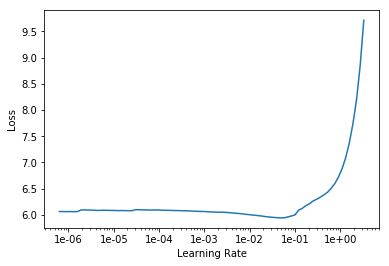

In [16]:
lm_learner.fit_one_cycle(cyc_len=1, max_lr=1e-2)
lm_learner.lr_find()
lm_learner.recorder.plot()
lm_learner.save_encoder('ft_enc')

In [0]:
clas_data = TextClasDataBunch.from_df(train_df = dataset_trn, valid_df = dataset_tst, vocab=lm_data.train_ds.vocab, path = "")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.605494,0.574347,0.706517,00:04


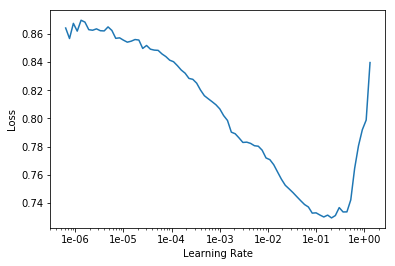

In [18]:
config = awd_lstm_clas_config.copy()
config['n_hid'] = 1150
tc_learner = text_classifier_learner(clas_data, arch=AWD_LSTM, drop_mult=drop_mult, config=config)
tc_learner.load_encoder('ft_enc')
tc_learner.lr_find()
tc_learner.recorder.plot()
tc_learner.fit_one_cycle(cyc_len=1, max_lr=1e-2)

# Evaluate model

In [19]:
predictions, targets = tc_learner.get_preds()
predictions

tensor([[0.6377, 0.3623],
        [0.2358, 0.7642],
        [0.3785, 0.6215],
        ...,
        [0.6161, 0.3839],
        [0.7355, 0.2645],
        [0.7131, 0.2869]])

In [20]:
predictions = np.argmax(predictions, axis = 1)

test_accuracy = 100 * int((predictions==targets).sum())/len(predictions)
print(f"Test accuracy:\n{test_accuracy:.1f}%\n")

print("Confusion matrix:")
pd.crosstab(predictions, targets)

Test accuracy:
70.7%

Confusion matrix:


col_0,0,1
row_0,,
0,727,287
1,339,780
